<a href="https://colab.research.google.com/github/myy04/Real-Fake-Image-Classifier/blob/main/CLIP_fine_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch [1/10], Batch [0/391], Loss: 1.7805


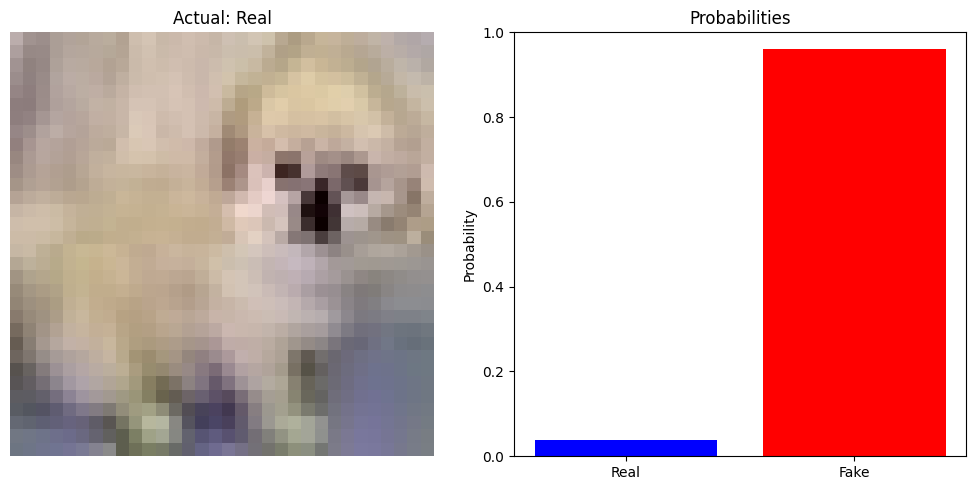

Epoch [1/10], Batch [100/391], Loss: 0.6470


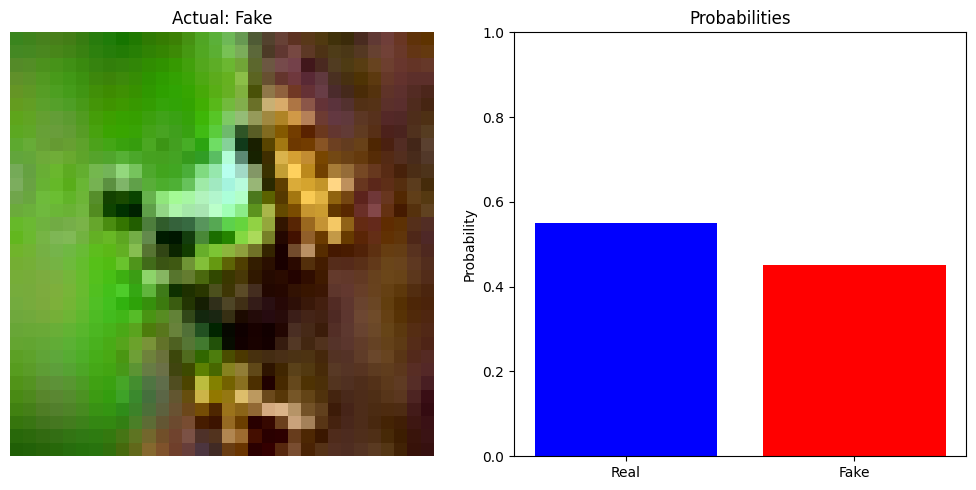

Epoch [1/10], Batch [200/391], Loss: 0.6272


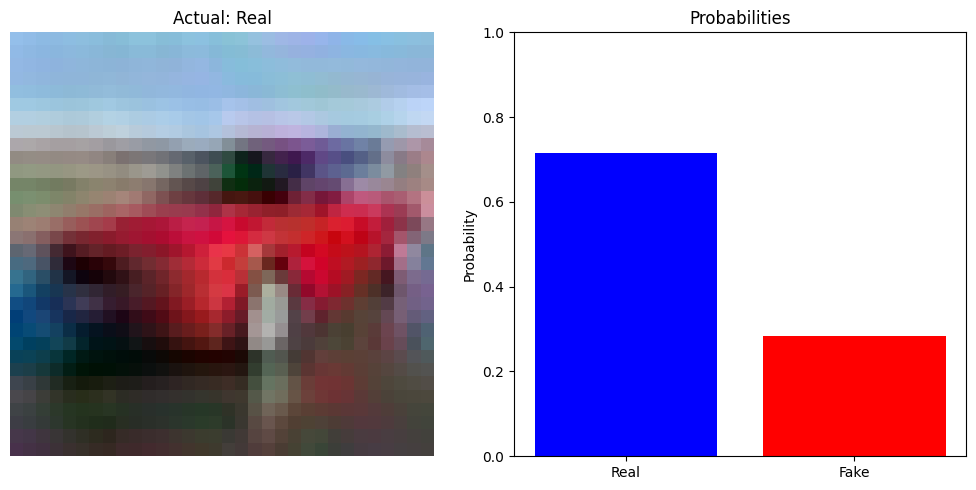

Epoch [1/10], Batch [300/391], Loss: 0.6247


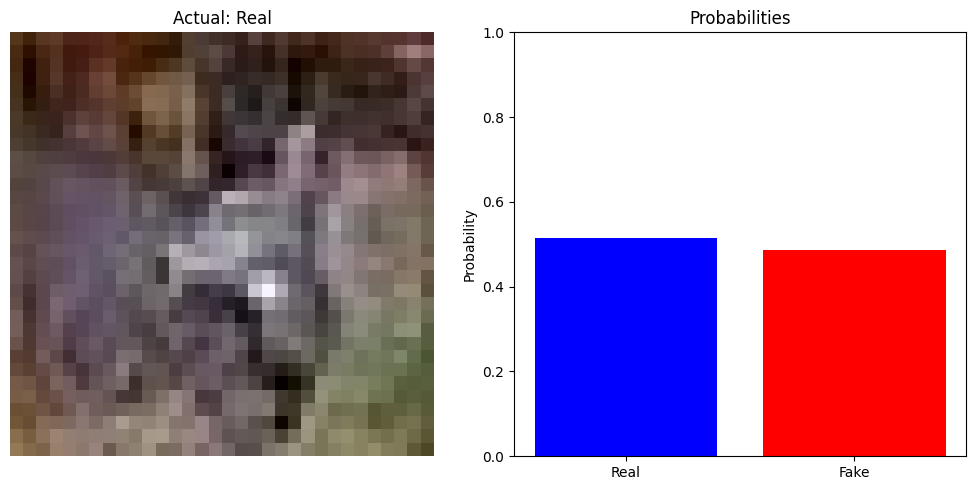

Epoch [1/10] Evaluation:
Accuracy: 65.625
Precision: 0.65
Recall: 0.89
F1 Score: 0.76
Epoch [2/10], Batch [0/391], Loss: 0.6103


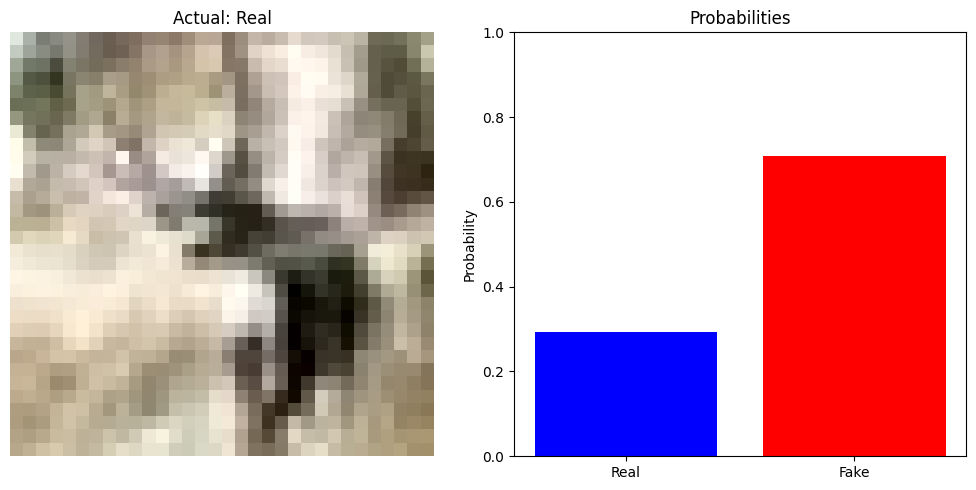

Epoch [2/10], Batch [100/391], Loss: 0.5879


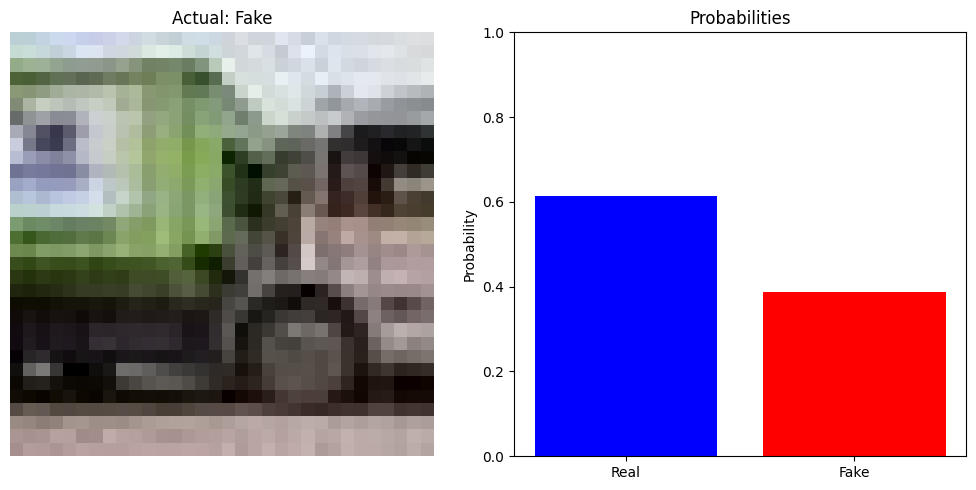

Epoch [2/10], Batch [200/391], Loss: 0.5729


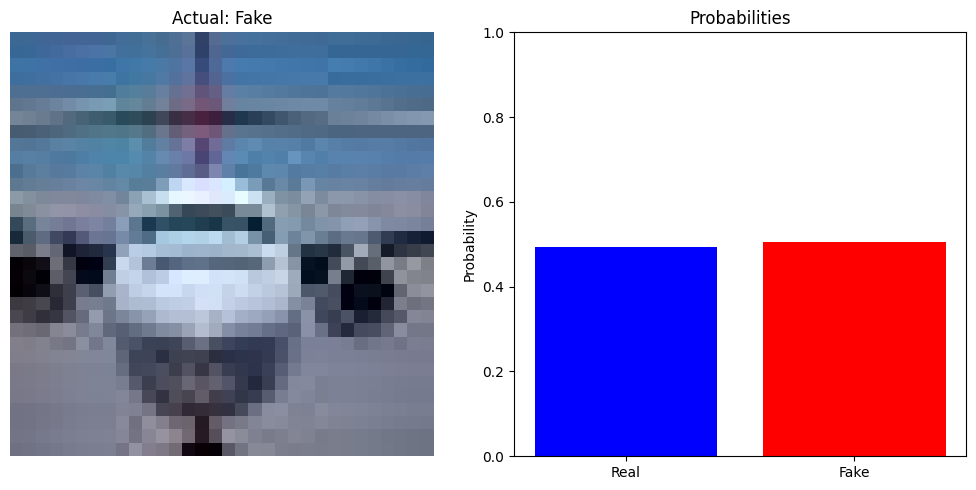

Epoch [2/10], Batch [300/391], Loss: 0.6104


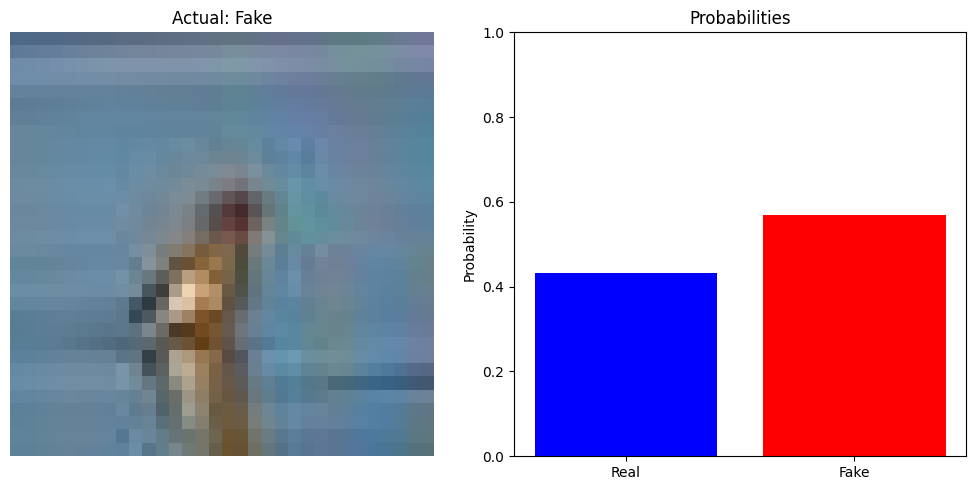

Epoch [2/10] Evaluation:
Accuracy: 59.375
Precision: 0.83
Recall: 0.48
F1 Score: 0.61
Epoch [3/10], Batch [0/391], Loss: 0.5502


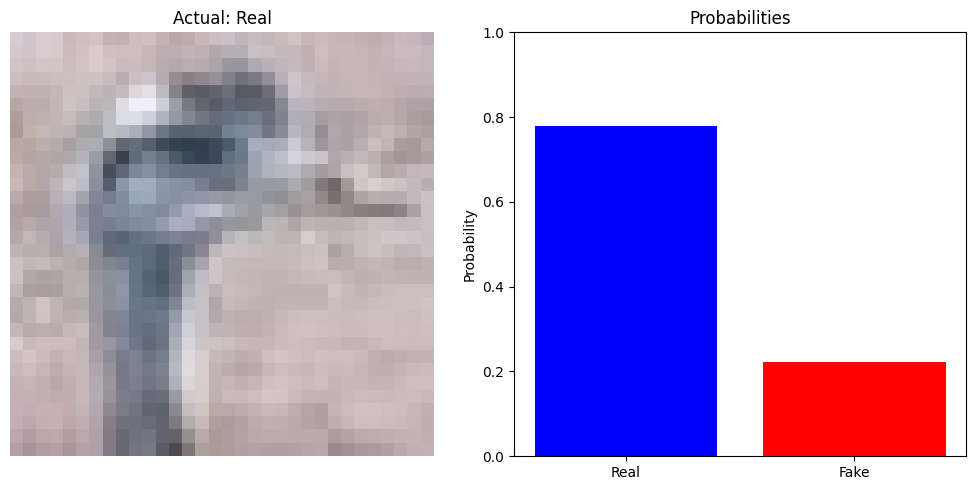

Epoch [3/10], Batch [100/391], Loss: 0.5844


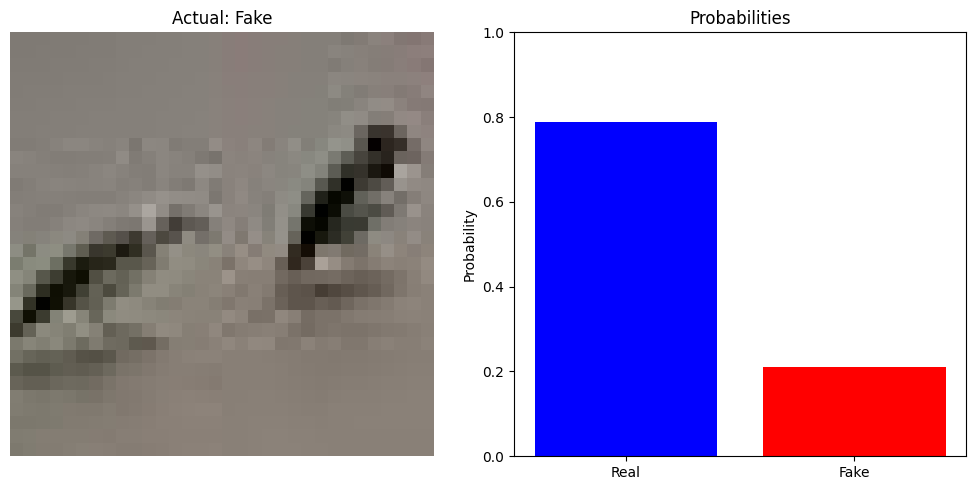

Epoch [3/10], Batch [200/391], Loss: 0.5822


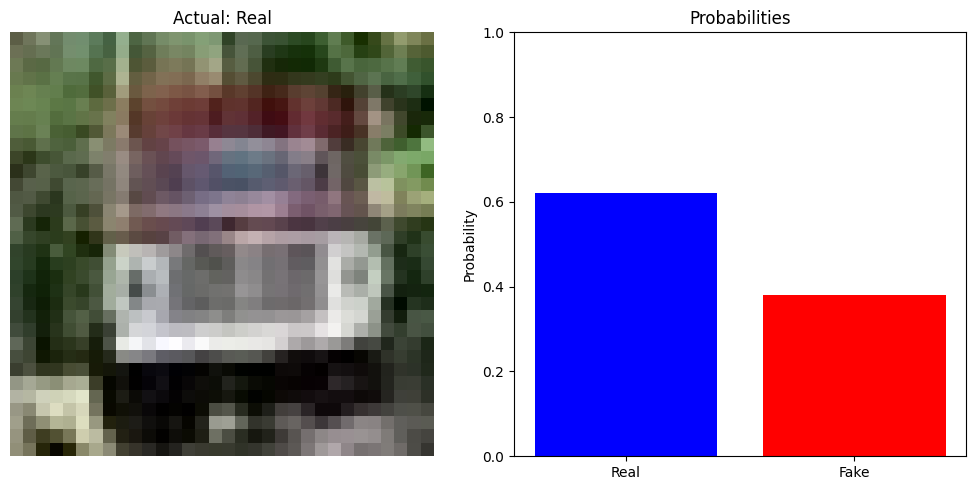

Epoch [3/10], Batch [300/391], Loss: 0.5929


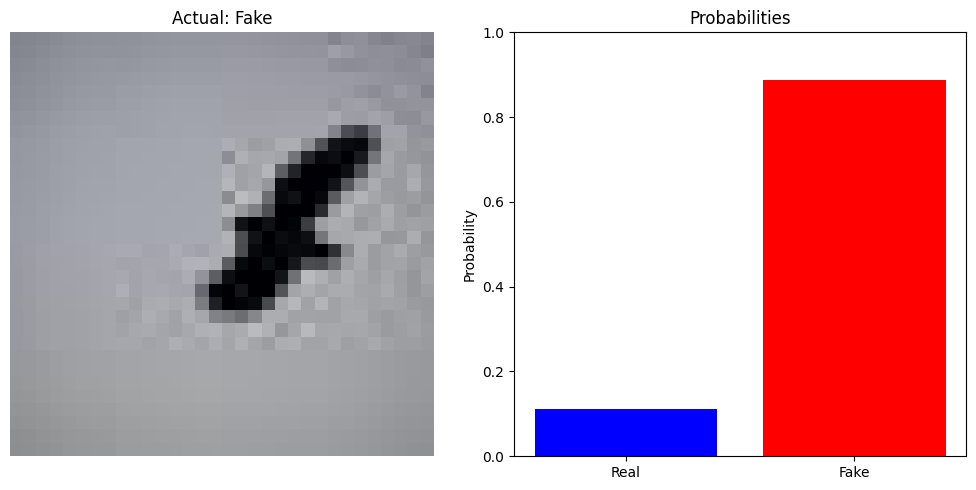

Epoch [3/10] Evaluation:
Accuracy: 75.0
Precision: 0.71
Recall: 0.88
F1 Score: 0.79
Epoch [4/10], Batch [0/391], Loss: 0.5540


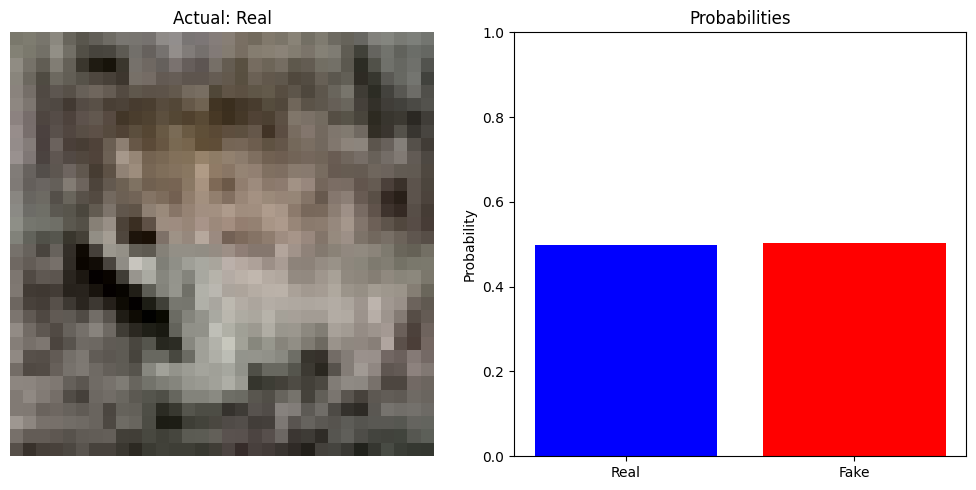

Epoch [4/10], Batch [100/391], Loss: 0.5332


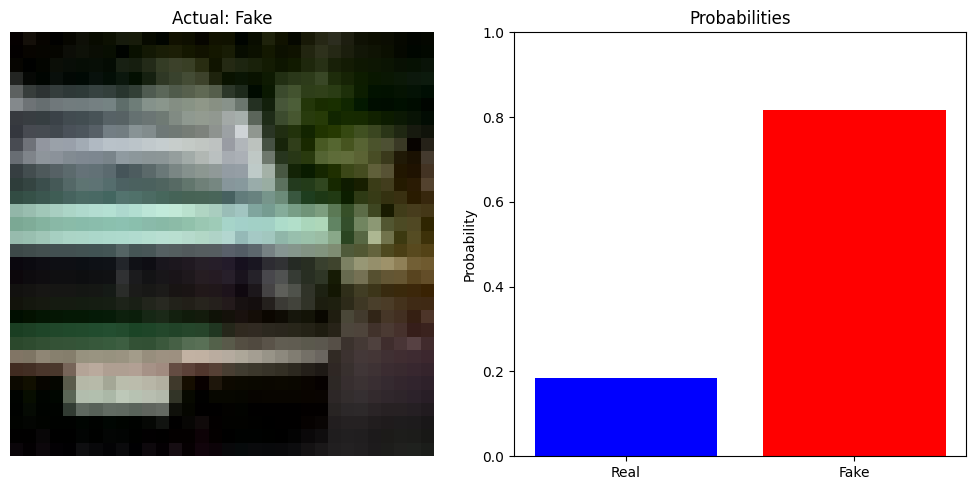

Epoch [4/10], Batch [200/391], Loss: 0.5172


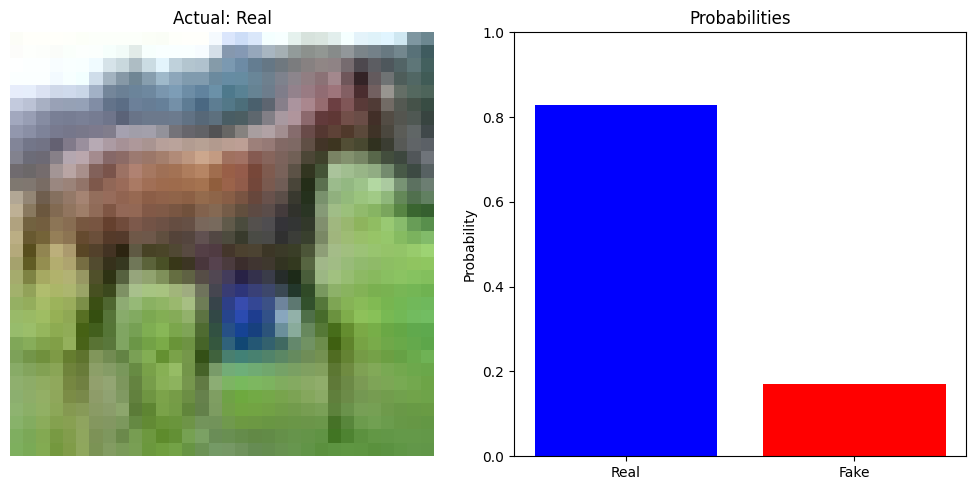

Epoch [4/10], Batch [300/391], Loss: 0.5801


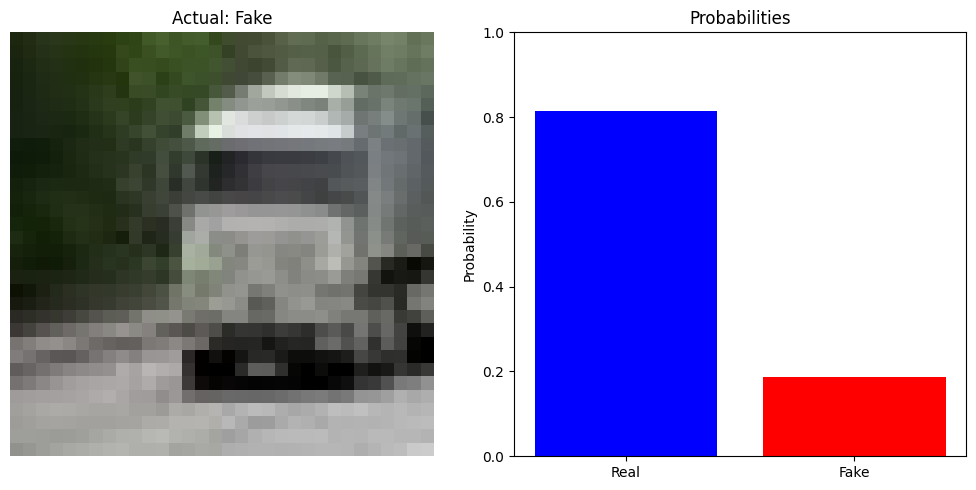

Epoch [4/10] Evaluation:
Accuracy: 75.0
Precision: 1.00
Recall: 0.43
F1 Score: 0.60
Epoch [5/10], Batch [0/391], Loss: 0.5465


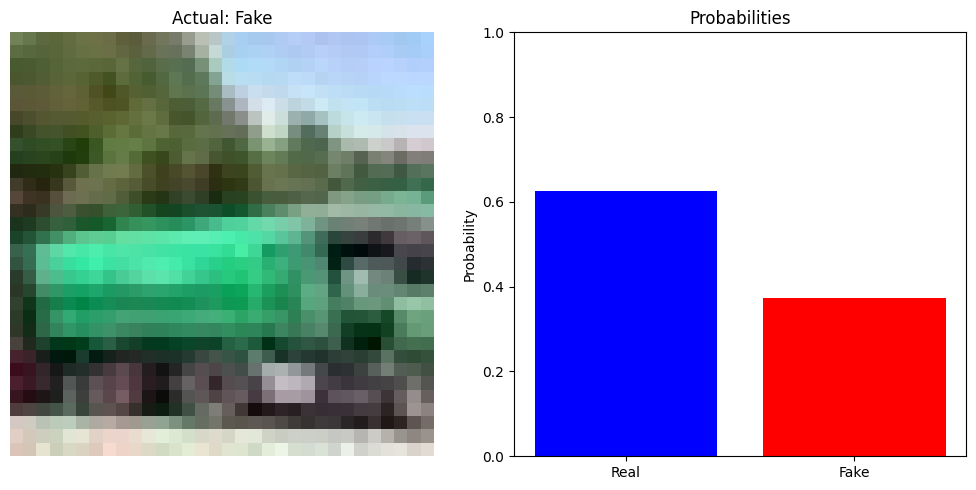

Epoch [5/10], Batch [100/391], Loss: 0.4793


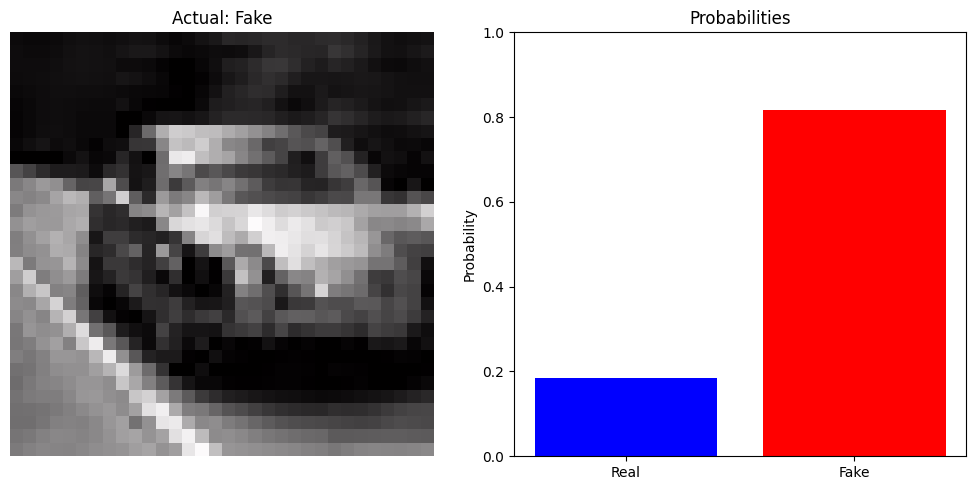

Epoch [5/10], Batch [200/391], Loss: 0.4935


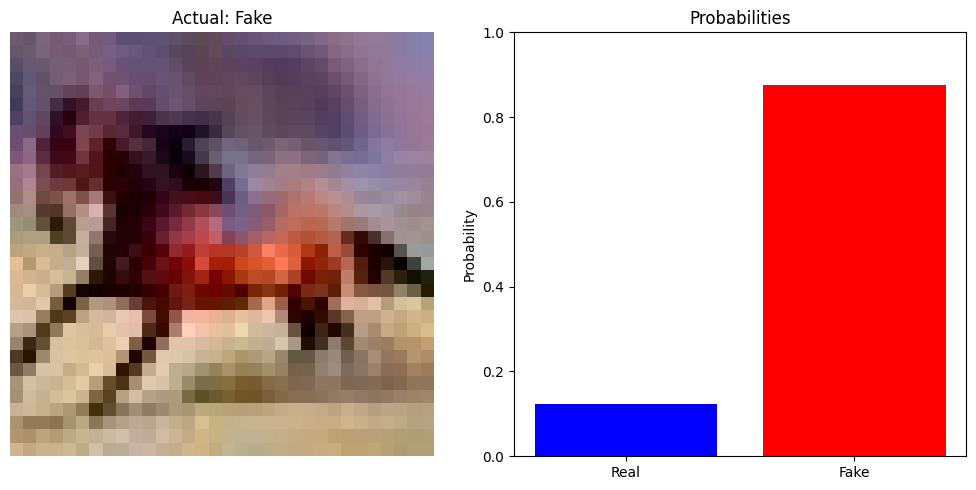

Epoch [5/10], Batch [300/391], Loss: 0.5251


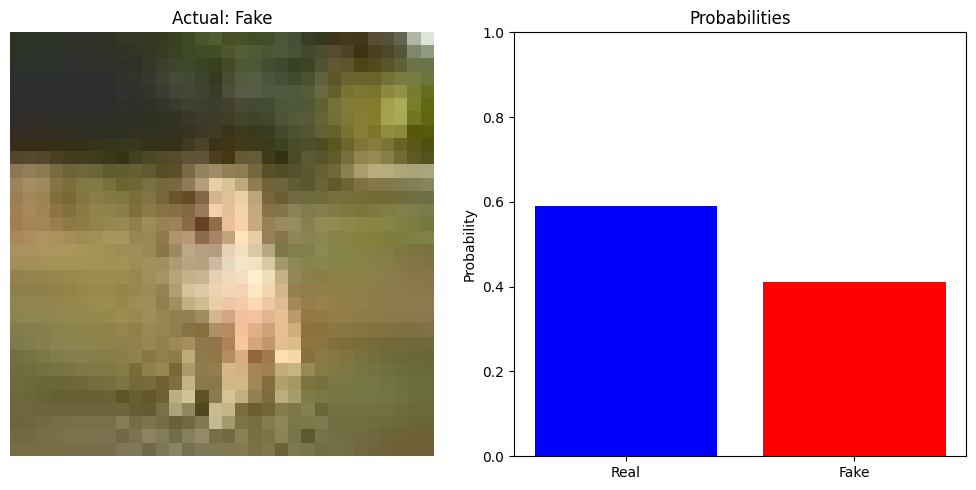

Epoch [5/10] Evaluation:
Accuracy: 71.875
Precision: 0.56
Recall: 0.91
F1 Score: 0.69
Epoch [6/10], Batch [0/391], Loss: 0.5120


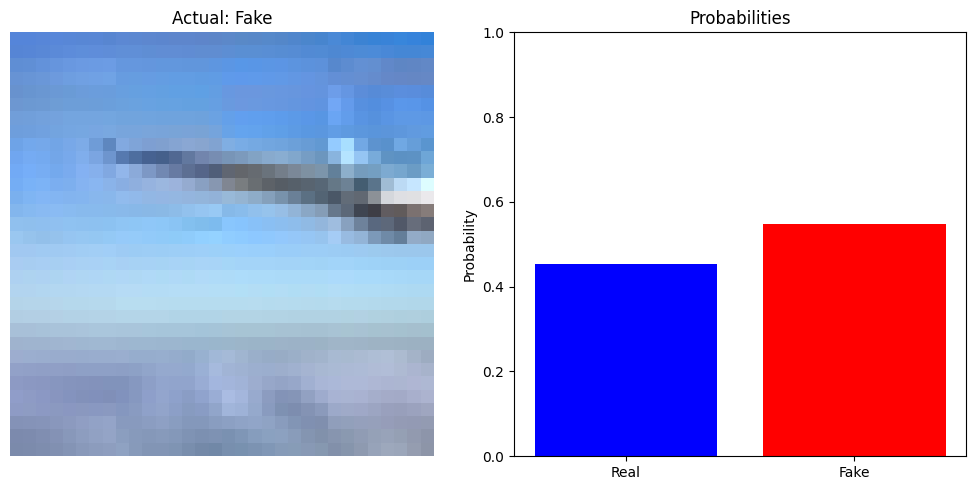

Epoch [6/10], Batch [100/391], Loss: 0.4919


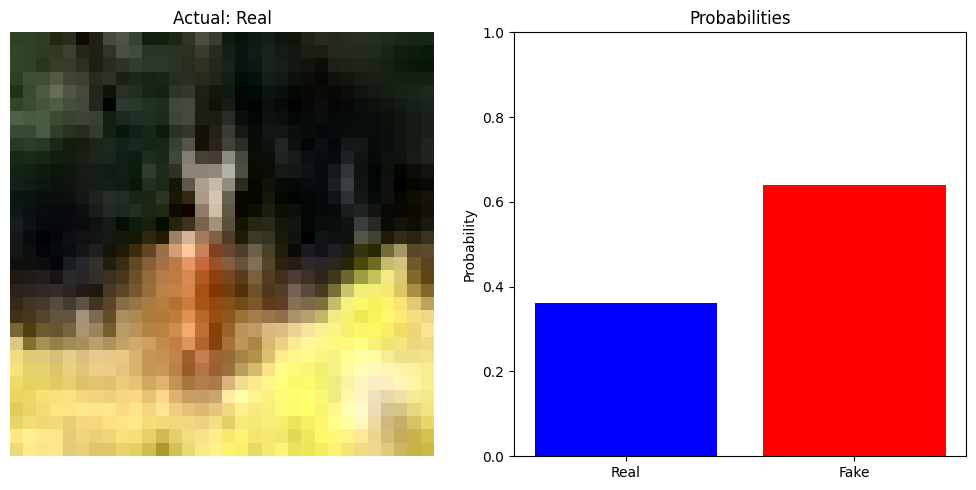

Epoch [6/10], Batch [200/391], Loss: 0.4762


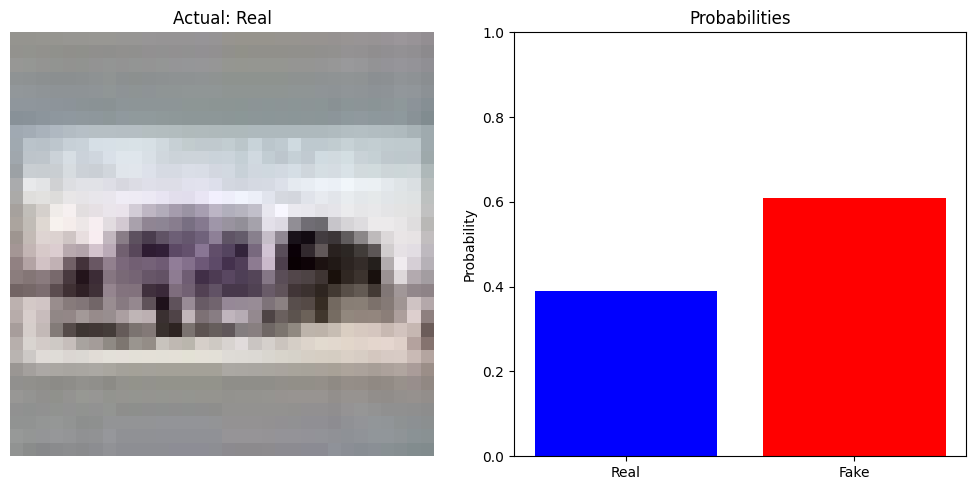

Epoch [6/10], Batch [300/391], Loss: 0.4782


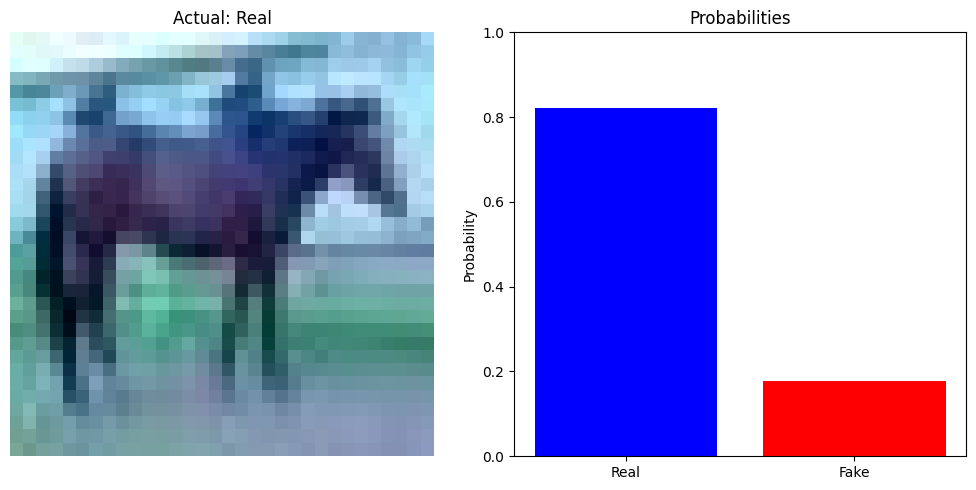

Epoch [6/10] Evaluation:
Accuracy: 75.0
Precision: 0.80
Recall: 0.57
F1 Score: 0.67
Epoch [7/10], Batch [0/391], Loss: 0.5213


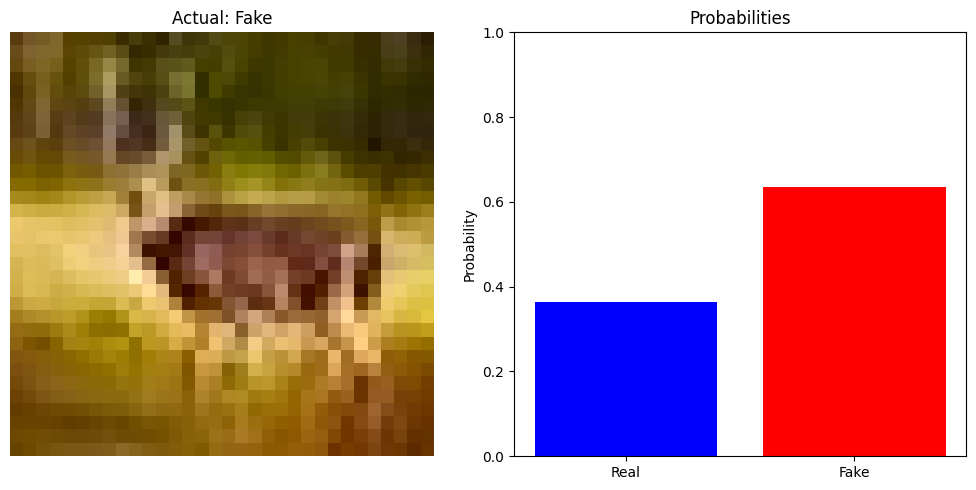

Epoch [7/10], Batch [100/391], Loss: 0.5025


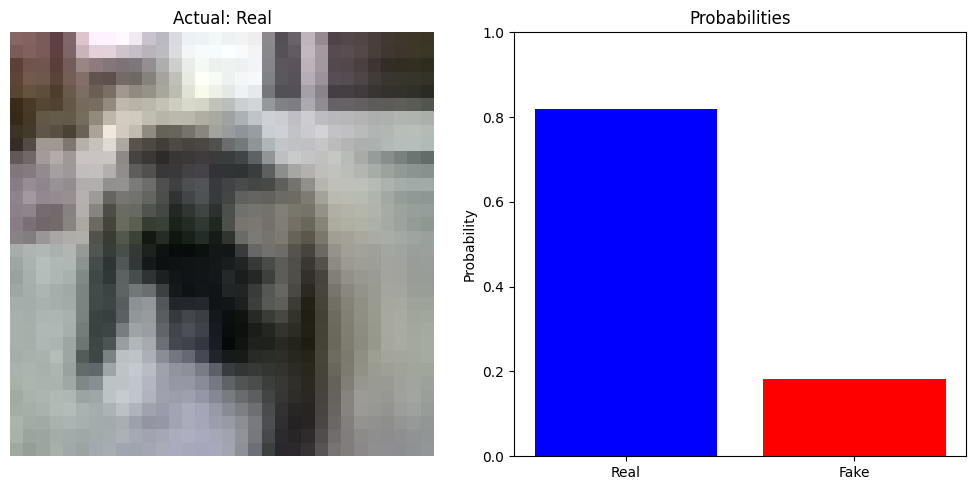

Epoch [7/10], Batch [200/391], Loss: 0.5157


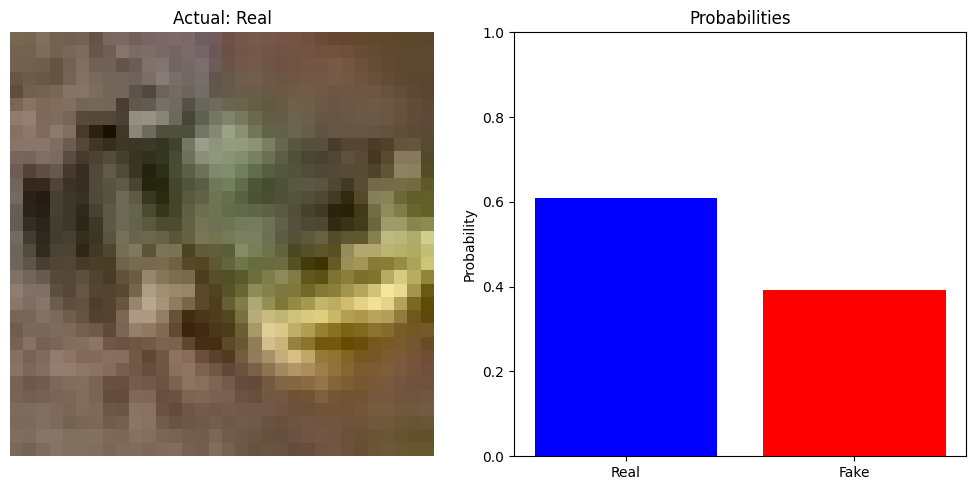

Epoch [7/10], Batch [300/391], Loss: 0.4954


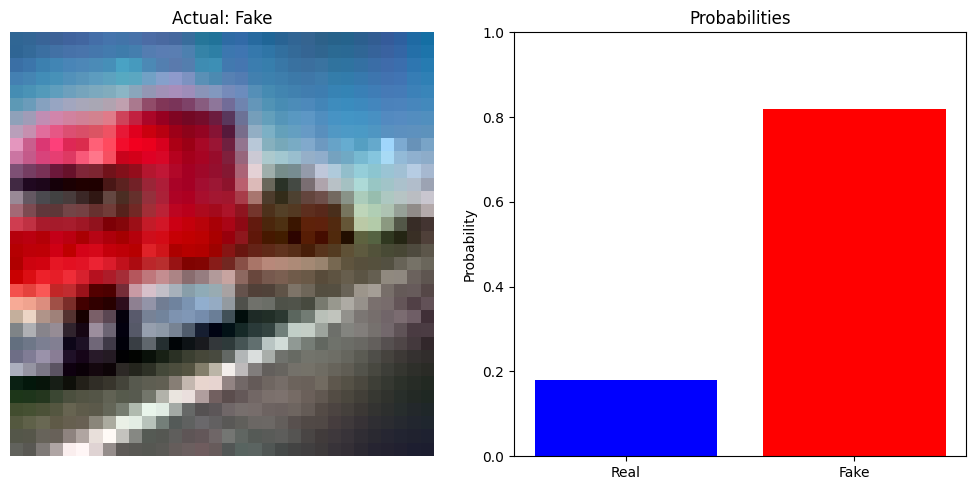

Epoch [7/10] Evaluation:
Accuracy: 78.125
Precision: 0.70
Recall: 0.93
F1 Score: 0.80
Epoch [8/10], Batch [0/391], Loss: 0.4854


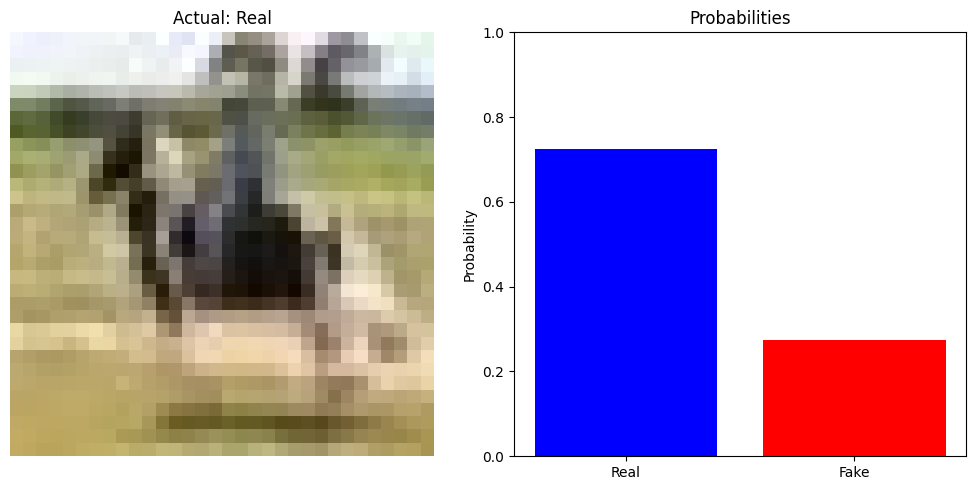

Epoch [8/10], Batch [100/391], Loss: 0.4511


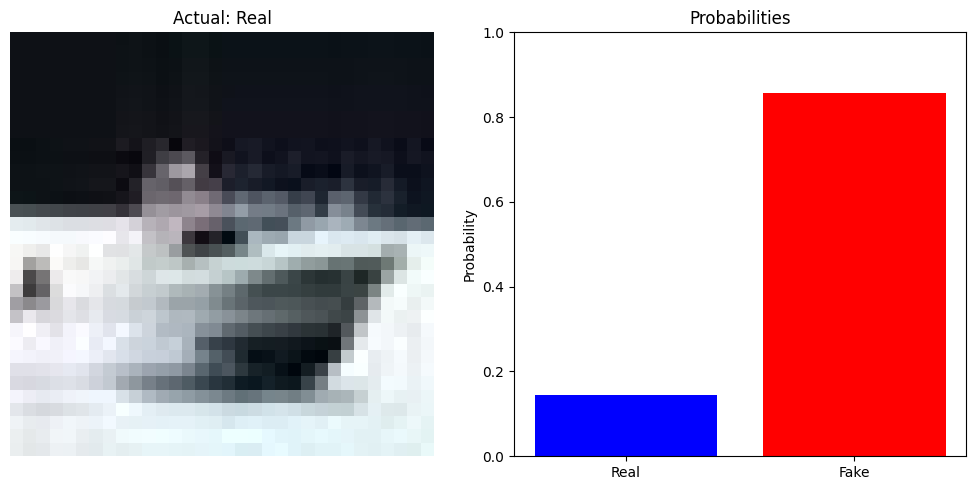

Epoch [8/10], Batch [200/391], Loss: 0.4171


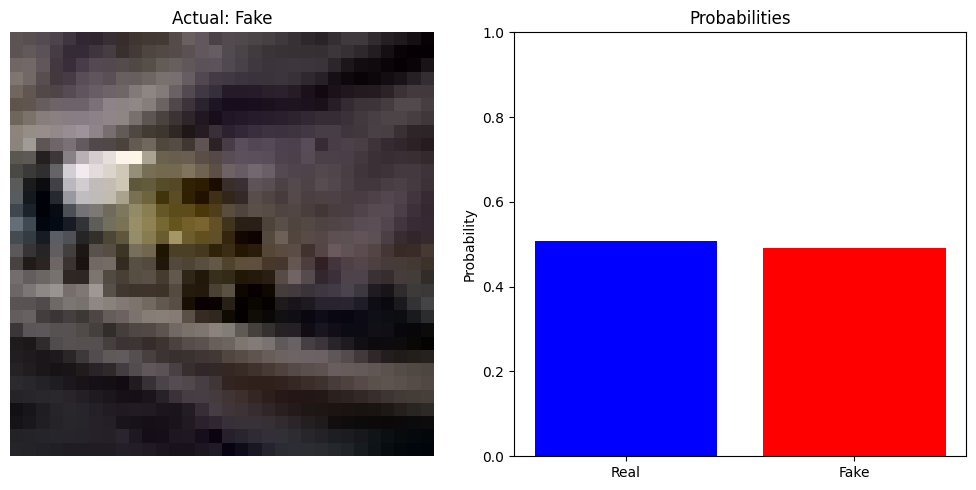

Epoch [8/10], Batch [300/391], Loss: 0.4245


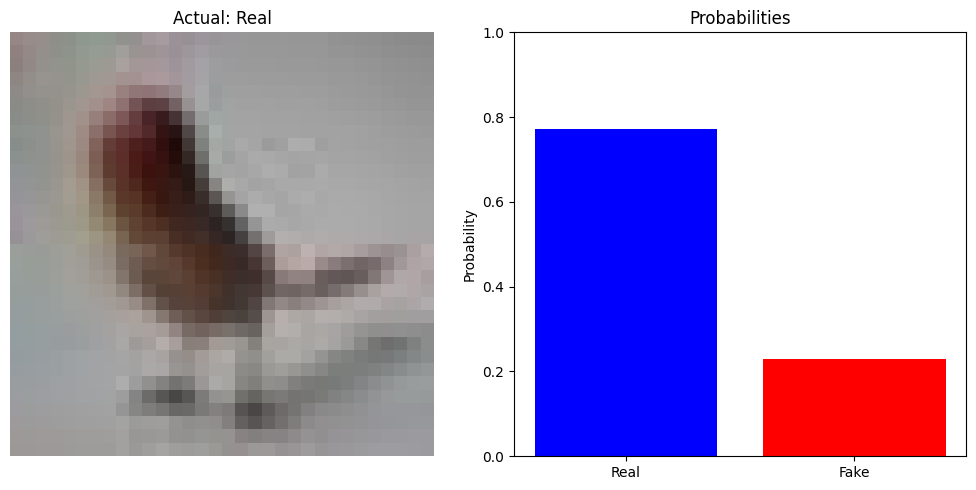

Epoch [8/10] Evaluation:
Accuracy: 75.0
Precision: 1.00
Recall: 0.56
F1 Score: 0.71
Epoch [9/10], Batch [0/391], Loss: 0.4687


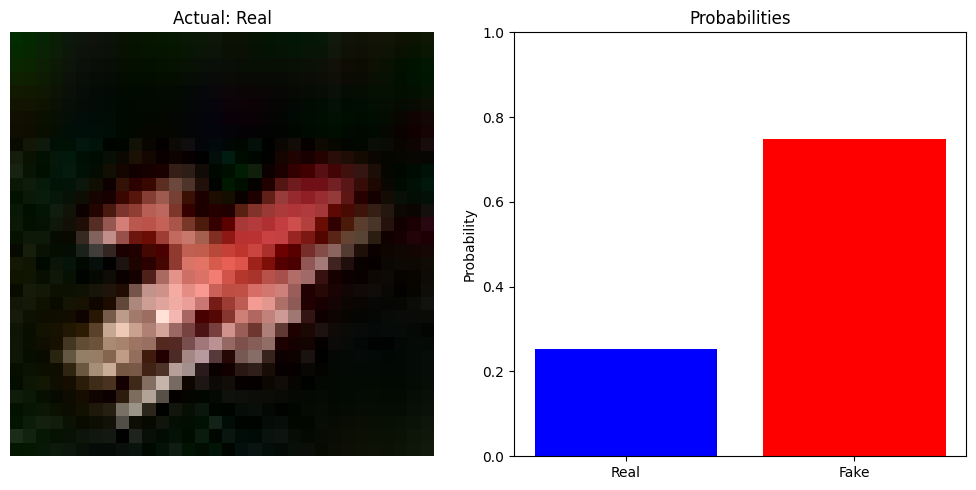

Epoch [9/10], Batch [100/391], Loss: 0.4992


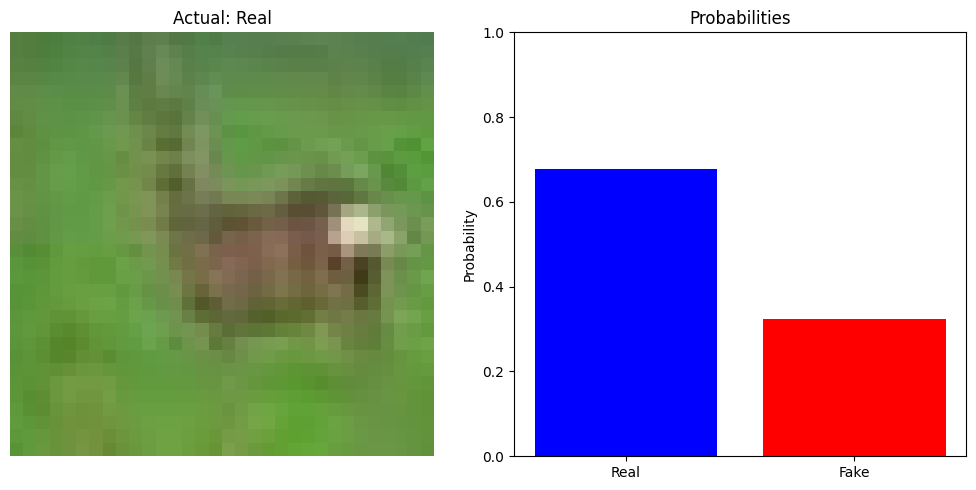

Epoch [9/10], Batch [200/391], Loss: 0.4217


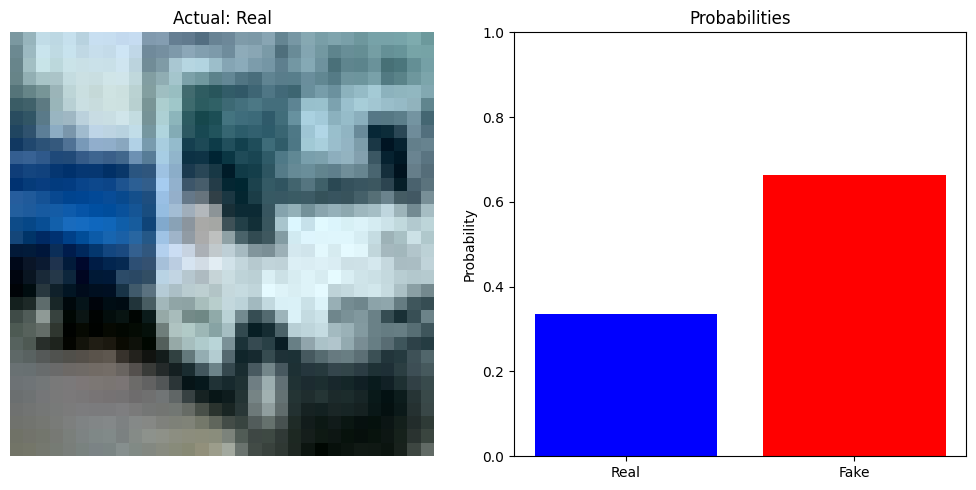

Epoch [9/10], Batch [300/391], Loss: 0.4438


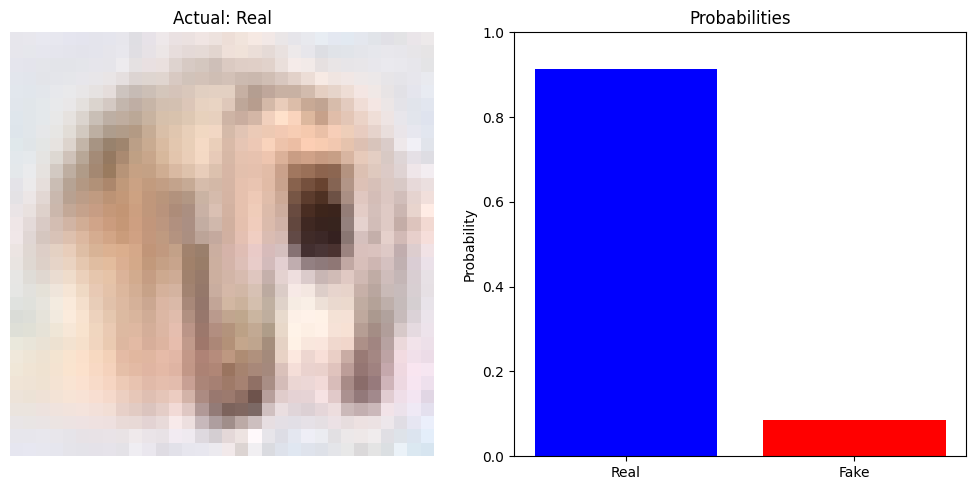

Epoch [9/10] Evaluation:
Accuracy: 81.25
Precision: 0.83
Recall: 0.71
F1 Score: 0.77
Epoch [10/10], Batch [0/391], Loss: 0.5001


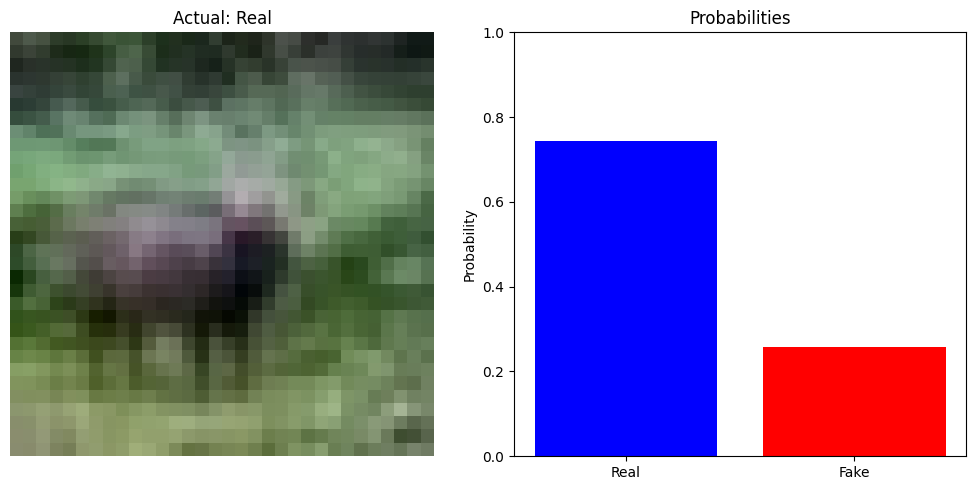

Epoch [10/10], Batch [100/391], Loss: 0.4384


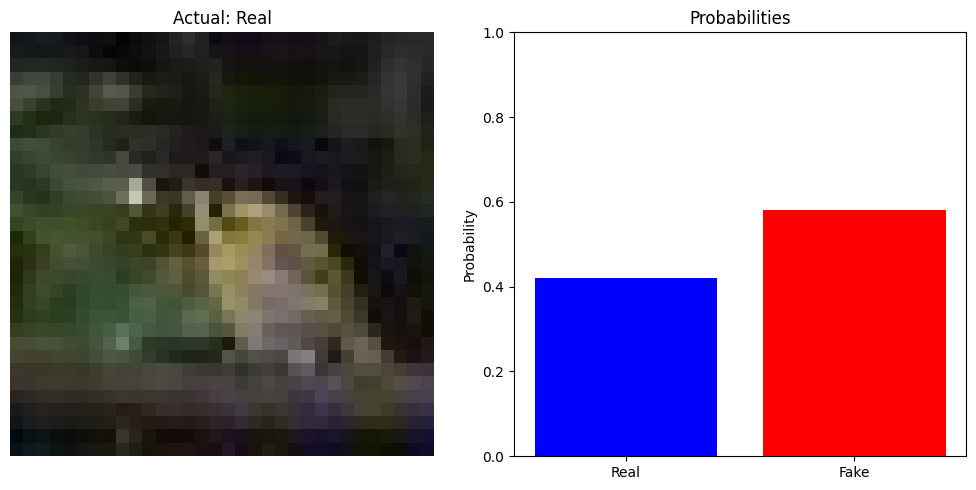

Epoch [10/10], Batch [200/391], Loss: 0.4920


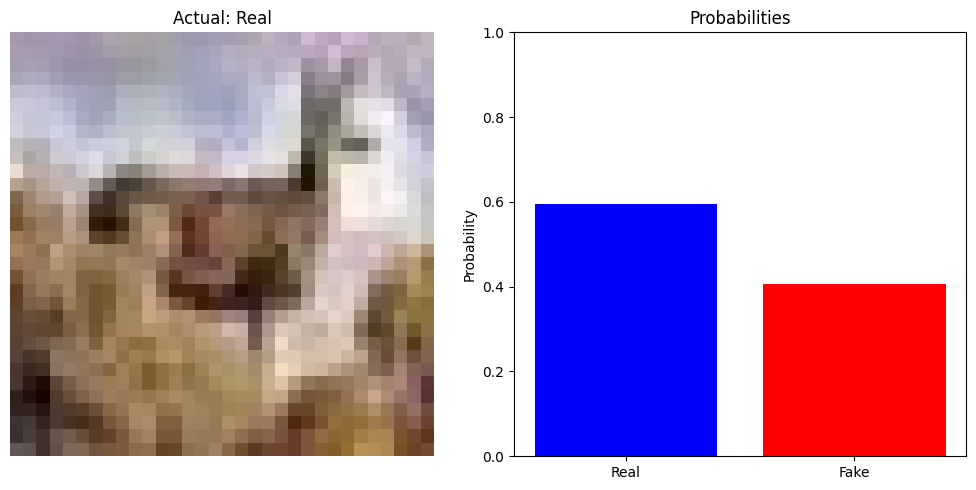

Epoch [10/10], Batch [300/391], Loss: 0.4754


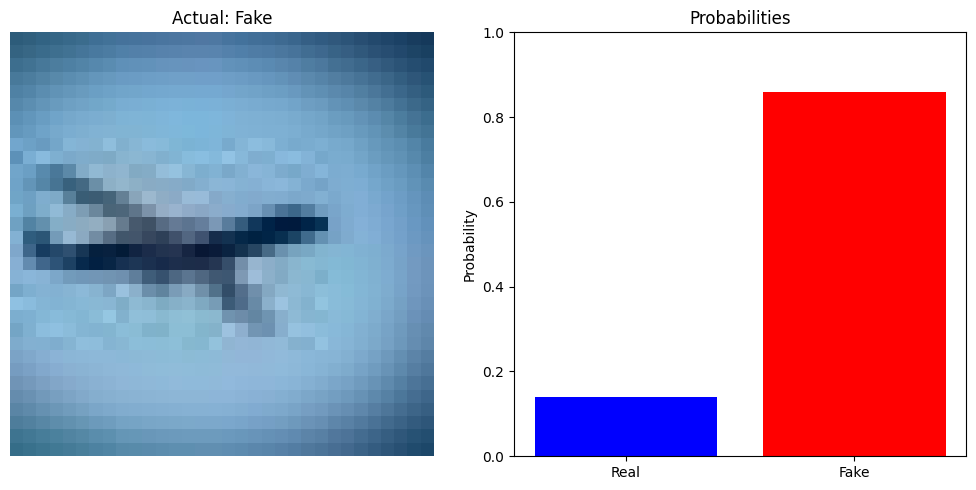

Epoch [10/10] Evaluation:
Accuracy: 78.125
Precision: 0.76
Recall: 0.81
F1 Score: 0.79
Model parameters saved to fine_tuned_clip_model.pth


In [ ]:
!pip install scikit-learn matplotlib
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoModel, AutoProcessor, get_linear_schedule_with_warmup
import os
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from torch.optim.lr_scheduler import CosineAnnealingLR

import warnings
warnings.filterwarnings("ignore")

import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

text = ["a real image", "a digitally generated image"]

class ImageDataset(Dataset):
    def __init__(self, path, transform):

        self.transform = transform

        real_images_directory = os.path.join(path, 'REAL')
        fake_images_directory = os.path.join(path, 'FAKE')

        real_images = []
        fake_images = []

        for file in os.listdir(real_images_directory):
            real_images.append(os.path.join(real_images_directory, file))

        for file in os.listdir(fake_images_directory):
            fake_images.append(os.path.join(fake_images_directory, file))

        self.images = []
        for i in range(min(len(real_images), len(fake_images))):
            self.images.append((real_images[i], torch.tensor([1, 0], dtype = torch.float32)))
            self.images.append((fake_images[i], torch.tensor([0, 1], dtype = torch.float32)))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx][0]).convert("RGB")
        image = self.transform(image) # Apply transform if provided
        return image, self.images[idx][1]

transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization to ImageNet stats
])



# Create the dataset instance with the transform
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")

for name, param in model.named_parameters():
    if 'text_model' in name or 'vision_model.encoder' in name :  # Freeze text encoder and early vision layers
        param.requires_grad = False
    else:  # Unfreeze the last layers for fine-tuning
        param.requires_grad = True


train_dataset = ImageDataset(os.path.join(path, 'train'), transform)
eval_dataset = ImageDataset(os.path.join(path, 'test'), transform)

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# text = []
# text += [f"a photo of a genuine {label}" for label in labels]  # More specific for real
# text += [f"a digitally generated image of a {label}" for label in labels]  # More specific for fake


# Create DataLoaders for batch processing
batch_size = 256  # You can adjust the batch size
num_epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# Fine-tuning setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3) # Optimize only unfrozen layers
criterion = nn.CrossEntropyLoss()

num_training_steps = len(train_loader) * num_epochs
scheduler = CosineAnnealingLR(optimizer, T_max=num_training_steps)

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (images, labels_batch) in enumerate(train_loader):
        images, labels_batch = images.to(device), labels_batch.to(device)

        optimizer.zero_grad()

        inputs = clip_processor(text=text, images=images, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)

        logits_per_image = outputs.logits_per_image

        loss = criterion(logits_per_image, labels_batch.argmax(dim=1)) # Calculate loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Add this line after loss.backward()
        optimizer.step()
        scheduler.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

            # Visualization for the first image in the batch
            image = images[0].cpu()  # Move to CPU for visualization
            probs = logits_per_image[0].softmax(dim=0).cpu().detach().numpy()  # Get probabilities for the first image

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f"Actual: {'Fake' if labels_batch[0][1].item() else 'Real'}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            categories = ['Real', 'Fake']
            plt.bar(categories, probs, color=['blue', 'red'])
            plt.title('Probabilities')
            plt.ylabel('Probability')
            plt.ylim([0, 1])

            plt.tight_layout()
            plt.show()
    # Evaluation after each epoch
    model.eval()
    all_predicted_labels = []
    all_true_labels = []
    num_of_correct = 0
    total = 0

    with torch.no_grad():
      for images, labels_batch in eval_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)

      # Iterate over images in the batch
      for image, label in zip(images, labels_batch):
        inputs = clip_processor(text=text, images=[image.cpu()], return_tensors="pt", padding=True).to(device)  # Process each image individually
        outputs = model(**inputs)

        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        # Get predicted class
        predicted_class = probs.argmax(dim=1).item()  # Get predicted class for the single image

        total += 1  # Increment total count by 1 for each image
        num_of_correct += (predicted_class == label.argmax(dim=0).item())  # Compare with true label for the single image
        all_predicted_labels.append(predicted_class)  # Append predicted class for the single image
        all_true_labels.append(label.argmax(dim=0).item())  # Append true label for the single image


    precision = precision_score(all_true_labels, all_predicted_labels)
    recall = recall_score(all_true_labels, all_predicted_labels)
    f1 = f1_score(all_true_labels, all_predicted_labels)

    print(f"Epoch [{epoch+1}/{num_epochs}] Evaluation:")
    print(f'Accuracy: {num_of_correct / total * 100}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

torch.save(model.state_dict(), "fine_tuned_clip_model.pth")
print("Model parameters saved to fine_tuned_clip_model.pth")

In [33]:

path = kagglehub.dataset_download("ciplab/real-and-fake-face-detection")

print("Path to dataset files:", path)

class ImageDataset(Dataset):
    def __init__(self, path):


        real_images_directory = os.path.join(path, 'training_real')
        fake_images_directory = os.path.join(path, 'training_fake')

        real_images = []
        fake_images = []

        for file in os.listdir(real_images_directory):
            real_images.append(os.path.join(real_images_directory, file))

        for file in os.listdir(fake_images_directory):
            fake_images.append(os.path.join(fake_images_directory, file))

        self.images = []
        for i in range(min(len(real_images), len(fake_images))):
            self.images.append((real_images[i], torch.tensor([1, 0], dtype = torch.float32)))
            self.images.append((fake_images[i], torch.tensor([0, 1], dtype = torch.float32)))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx][0]).convert("RGB")
        image = transform(image) # Apply transform if provided
        return image, self.images[idx][1]


transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization to ImageNet stats
])


eval_dataset = ImageDataset(os.path.join(path, 'real_and_fake_face'))
eval_loader = DataLoader(eval_dataset, batch_size=256, shuffle=True)

# Evaluation loop with visualization and bar plot for 10 images
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score # Import accuracy_score

num_images_to_visualize = 10  # Total number of images to visualize
images_visualized = 0  # Counter for visualized images

model.load_state_dict(torch.load("fine_tuned_clip_model.pth")) #Assuming fine_tuned_clip_model.pth in current dir
model.eval()  # Set the model to evaluation mode

all_predicted_labels = []
all_true_labels = []
num_of_correct = 0
total = 0

with torch.no_grad():
  for images, labels_batch in eval_loader:
    images, labels_batch = images.to(device), labels_batch.to(device)

  # Iterate over images in the batch
    for image, label in zip(images, labels_batch):
      inputs = clip_processor(text=text, images=[image.cpu()], return_tensors="pt", padding=True).to(device)  # Process each image individually
      outputs = model(**inputs)

      logits_per_image = outputs.logits_per_image
      probs = logits_per_image.softmax(dim=1)

      # Get predicted class
      predicted_class = probs.argmax(dim=1).item()  # Get predicted class for the single image

      total += 1  # Increment total count by 1 for each image
      num_of_correct += (predicted_class == label.argmax(dim=0).item())  # Compare with true label for the single image
      all_predicted_labels.append(predicted_class)  # Append predicted class for the single image
      all_true_labels.append(label.argmax(dim=0).item())  # Append true label for the single image

      precision = precision_score(all_true_labels, all_predicted_labels)
      recall = recall_score(all_true_labels, all_predicted_labels)
      f1 = f1_score(all_true_labels, all_predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)

precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Evaluation on new dataset:")
print(f"Accuracy: {accuracy:.4f}") # Print accuracy
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")



Path to dataset files: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1
Evaluation on new dataset:
Accuracy: 0.4911
Precision: 0.4735
Recall: 0.1583
F1-score: 0.2373


In [34]:
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

text = ["a real image", "a digitally generated image"]

class ImageDataset(Dataset):
    def __init__(self, path, transform):

        self.transform = transform

        real_images_directory = os.path.join(path, 'REAL')
        fake_images_directory = os.path.join(path, 'FAKE')

        real_images = []
        fake_images = []

        for file in os.listdir(real_images_directory):
            real_images.append(os.path.join(real_images_directory, file))

        for file in os.listdir(fake_images_directory):
            fake_images.append(os.path.join(fake_images_directory, file))

        self.images = []
        for i in range(min(len(real_images), len(fake_images))):
            self.images.append((real_images[i], torch.tensor([1, 0], dtype = torch.float32)))
            self.images.append((fake_images[i], torch.tensor([0, 1], dtype = torch.float32)))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx][0]).convert("RGB")
        image = self.transform(image) # Apply transform if provided
        return image, self.images[idx][1]

transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
 #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization to ImageNet stats
])

eval_dataset = ImageDataset(os.path.join(path, 'test'), transform)
eval_loader = DataLoader(eval_dataset, batch_size=256, shuffle=True)


# Evaluation loop with visualization and bar plot for 10 images
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score # Import accuracy_score

num_images_to_visualize = 10  # Total number of images to visualize
images_visualized = 0  # Counter for visualized images

model.load_state_dict(torch.load("fine_tuned_clip_model.pth")) #Assuming fine_tuned_clip_model.pth in current dir
model.eval()  # Set the model to evaluation mode

all_predicted_labels = []
all_true_labels = []
num_of_correct = 0
total = 0

with torch.no_grad():
  for images, labels_batch in eval_loader:
    images, labels_batch = images.to(device), labels_batch.to(device)

  # Iterate over images in the batch
    for image, label in zip(images, labels_batch):
      inputs = clip_processor(text=text, images=[image.cpu()], return_tensors="pt", padding=True).to(device)  # Process each image individually
      outputs = model(**inputs)

      logits_per_image = outputs.logits_per_image
      probs = logits_per_image.softmax(dim=1)

      # Get predicted class
      predicted_class = probs.argmax(dim=1).item()  # Get predicted class for the single image

      total += 1  # Increment total count by 1 for each image
      num_of_correct += (predicted_class == label.argmax(dim=0).item())  # Compare with true label for the single image
      all_predicted_labels.append(predicted_class)  # Append predicted class for the single image
      all_true_labels.append(label.argmax(dim=0).item())  # Append true label for the single image

      precision = precision_score(all_true_labels, all_predicted_labels)
      recall = recall_score(all_true_labels, all_predicted_labels)
      f1 = f1_score(all_true_labels, all_predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)

precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Evaluation on new dataset:")
print(f"Accuracy: {accuracy:.4f}") # Print accuracy
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3
Evaluation on new dataset:
Accuracy: 0.6792
Precision: 0.9356
Recall: 0.3848
F1-score: 0.5453
